In [1]:
import pandas as pd
fptrain = "../../../data/cleaned_sba_7a_loans_train.parquet"
fptest = "../../../data/cleaned_sba_7a_loans_test.parquet"
fp_model_loc = r"../../../models/WOE_calibrated_classifier.pkl"

In [2]:
df_train = pd.read_parquet(fptrain)
df_test = pd.read_parquet(fptest)
df = pd.concat([df_train, df_test])

In [4]:
import pickle
with open(fp_model_loc , 'rb') as f:
    clf = pickle.load(f)

In [5]:
clf

CalibratedClassifierCV(cv=3,
                       estimator=LogisticRegressionCV(cv=5, random_state=0),
                       method='isotonic')

In [6]:
preds = df.columns.tolist()
preds = [p for p in preds if p not in["LoanStatus", "SBAGuaranteedApproval"]]

In [7]:
df_X = df[preds]
df_Y = df["LoanStatus"]

In [8]:
df_X.shape

(7838, 6)

In [15]:
charge_off_prob = clf.predict_proba(df_X)[:,1]

In [20]:
import numpy as np
import matplotlib.pyplot as plt
bins=np.logspace(np.log10(0.1),np.log10(1.0), 10)

(array([734., 402., 415., 280., 165., 375., 131.,  59., 101.]),
 array([0.1       , 0.12915497, 0.16681005, 0.21544347, 0.27825594,
        0.35938137, 0.46415888, 0.59948425, 0.77426368, 1.        ]),
 <BarContainer object of 9 artists>)

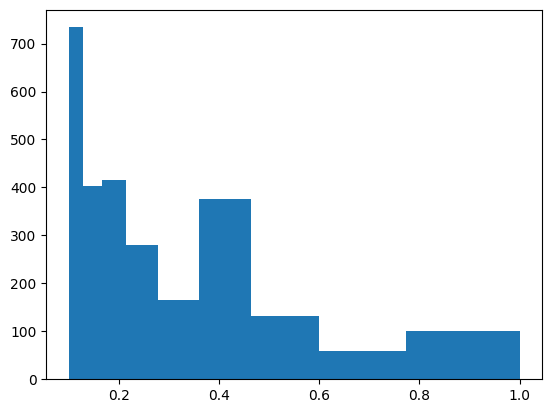

In [21]:
plt.hist(charge_off_prob, bins = bins)